In [1]:
# Constants
path_root = '/home/hwkang/jupyter/root/'
path_dataset = path_root + 'dataset/'
path_result_root = path_root + 'result/'
path_result = path_result_root + 'exp19/'
path_result_image = path_result + 'image/'
path_result_loss = path_result + 'loss/'
path_result_accuracy = path_result + 'accuracy/'
path_result_meta = path_result + 'meta/'
path_utility = path_root + 'utility/'

In [2]:
# Imports
import sys
sys.path.append(path_root)
sys.path.append(path_dataset)
sys.path.append(path_result)

In [3]:
# PyTorch family
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Utilities
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utility.common import *
from utility.preprocess import *
from utility.synthesize import *
from utility.visualize import *

In [4]:
ensure_directory(path_result)
ensure_directory(path_result_accuracy)
ensure_directory(path_result_image)
ensure_directory(path_result_loss)

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root=path_dataset,
                                 train=True,
                                 transform=transform,
                                 download=True)
test_dataset = datasets.CIFAR10(root=path_dataset,
                                 train=False,
                                 transform=transform,
                                 download=True)

train_dataset = get_subset(train_dataset, 0.1)
test_dataset = get_subset(test_dataset, 0.1)

train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

noised_train_dataset = NoisedDataset(train_loader)
noised_test_dataset = NoisedDataset(test_loader)

Files already downloaded and verified
Files already downloaded and verified


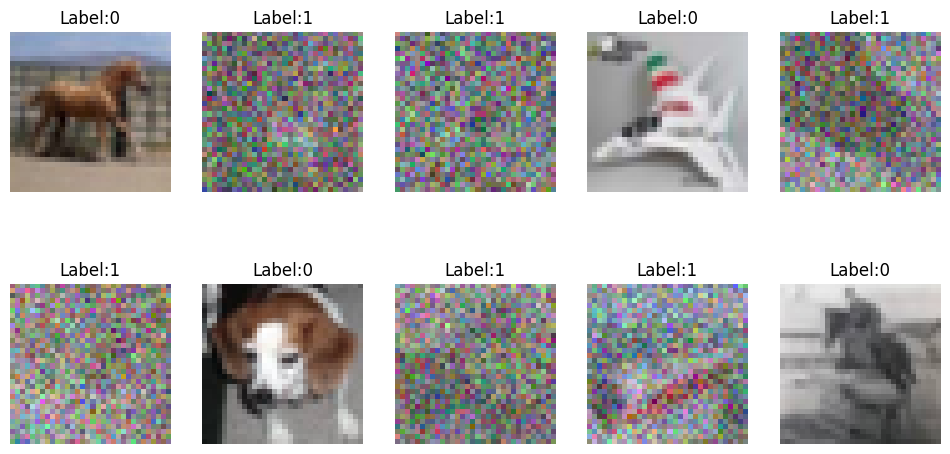

In [6]:
noised_train_loader = DataLoader(noised_train_dataset, batch_size=64, shuffle=True)
noised_test_loader = DataLoader(noised_test_dataset, batch_size=64, shuffle=False)

visualize_noisy_sample(pilot=True, loader=noised_test_loader)

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 첫 번째 합성곱 레이어
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # 두 번째 합성곱 레이어
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 세 번째 합성곱 레이어
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 완전 연결 레이어
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        # 첫 번째 합성곱 + ReLU + 풀링
        x = self.pool(F.relu(self.conv1(x)))
        # 두 번째 합성곱 + ReLU + 풀링
        x = self.pool(F.relu(self.conv2(x)))
        # 세 번째 합성곱 + ReLU + 풀링
        x = self.pool(F.relu(self.conv3(x)))
        # 텐서를 평탄화
        x = x.view(-1, 1024)
        # 완전 연결 레이어 + ReLU
        x = F.relu(self.fc1(x))
        # 출력 레이어 (이진 분류)
        x = torch.sigmoid(self.fc2(x))
        return x

In [8]:
def fgsm_attack(model, criterion, images, labels, epsilon):
    # 입력 데이터의 기울기를 추적
    images.requires_grad = True

    # 모델의 예측값 계산
    outputs = model(images)
    loss = criterion(outputs, labels)

    # 모델의 기울기를 0으로 설정하고 역전파 수행
    model.zero_grad()
    loss.backward()

    # 기울기의 부호를 구함
    sign_data_grad = images.grad.data.sign()

    # 입력 데이터에 교란 추가
    perturbed_images = images + epsilon * sign_data_grad

    # 데이터 값을 [0,1] 범위로 클립
    perturbed_images = torch.clamp(perturbed_images, 0, 1)

    return perturbed_images

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN()
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in noised_train_loader:
        # 이진 분류를 위해 라벨을 0 또는 1로 변경 (임시로)
        labels = labels.float().unsqueeze(1)

        inputs, labels = inputs.to(device), labels.to(device)
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # 순전파
        outputs = model(inputs)
        
        # 손실 계산
        loss = criterion(outputs, labels)
        
        # 역전파
        loss.backward()
        
        # 옵티마이저 업데이트
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(noised_train_loader.dataset)
    if( epoch % 10 == 9 ):
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

/home/hwkang/jupyter/venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 10/50, Loss: 0.0687
Epoch 20/50, Loss: 0.0653
Epoch 30/50, Loss: 0.0365
Epoch 40/50, Loss: 0.0164
Epoch 50/50, Loss: 0.0006


In [41]:
# Generate FGSM dataset
epsilon = 1e-3
fgsm_data = []

for images, labels in noised_test_loader:
    labels = labels.float().unsqueeze(1)
    images, labels = images.to(device), labels.to(device)

    perturbed_images = fgsm_attack(model, criterion, images, labels, epsilon)

    fgsm_data.append((perturbed_images.cpu().detach(), labels.int().cpu().detach()))

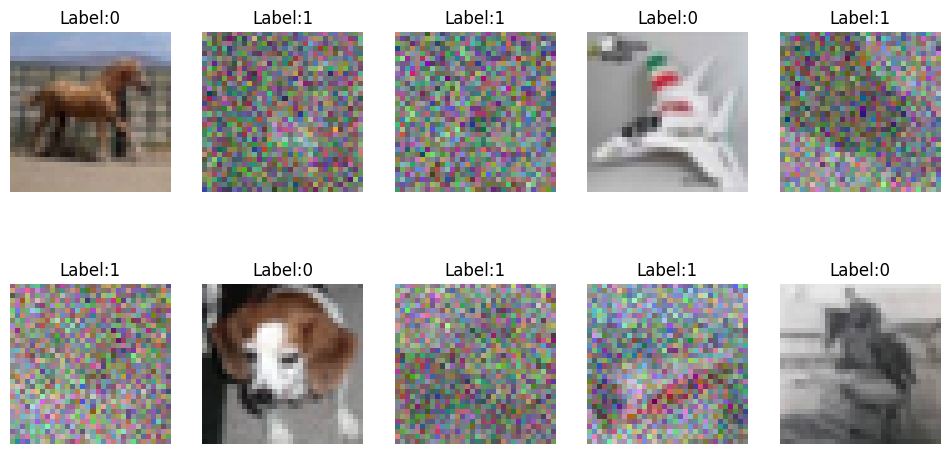

In [42]:
visualize_noisy_sample(pilot=True, loader=fgsm_data)

In [43]:
# 모델 평가
model.eval()
all_labels = []
all_predictions = []
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in fgsm_data:
        #labels = labels.float().unsqueeze(1)  # 이진 분류를 위해 라벨을 0 또는 1로 변경 (임시로)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        #print(outputs.max(), outputs.min())
        predicted = (outputs >= 0.5).float()
        #print(predicted.max(), predicted.min())
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        total += labels.size(0)
        a = (predicted == labels).sum()
        b = (predicted == labels)
        correct += (predicted == labels).sum().item()
        #print(len(predicted), len(labels))
        #print(total, correct)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 97.90%


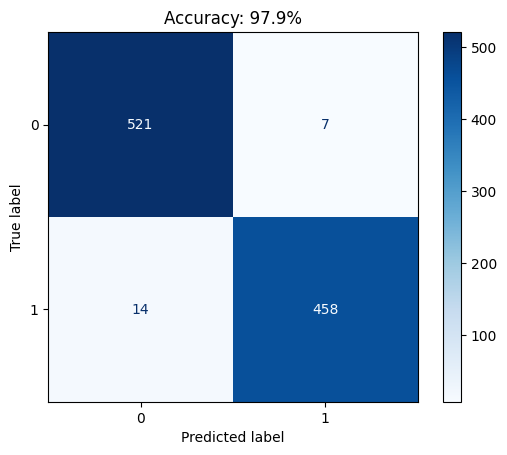

In [44]:
visualize_confusion_matrix(pilot=True, accuracy=accuracy, all_labels=all_labels, all_predictions=all_predictions, num_label=2)